### Read Data


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from scipy.stats import anderson_ksamp

# Get data source
data_dir = 'data_process/12-06/'

# RR
rr = data_dir + 'afterPI_rr_1207_1initdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv'

# AA, WSR, RSR
aa_wsr_rsr = data_dir + 'afterPI_1207_3params_2_train_test_split_repeats_data_rep500.csv'

# Read in as dataframe.
df_aa_wsr_rsr = pd.read_csv(aa_wsr_rsr)
df_rr = pd.read_csv(rr)

# Columns
SIM_AA = 'sim_aas'
SIM_WSR = 'sim_wsrs'
SIM_RSR = 'sim_rsrs'
SIM_RRTC = 'Simulated and Tuned Durations'
SIM_RRER = 'Simulated and Tuned Errors'
HUM_AA = 'hum_test_aas'
HUM_WSR = 'hum_test_wsrs'
HUM_RSR = 'hum_test_rsrs'
HUM_RRTC = 'Human Test Durations'
HUM_RRER = 'Human Test Errors'

### Plot

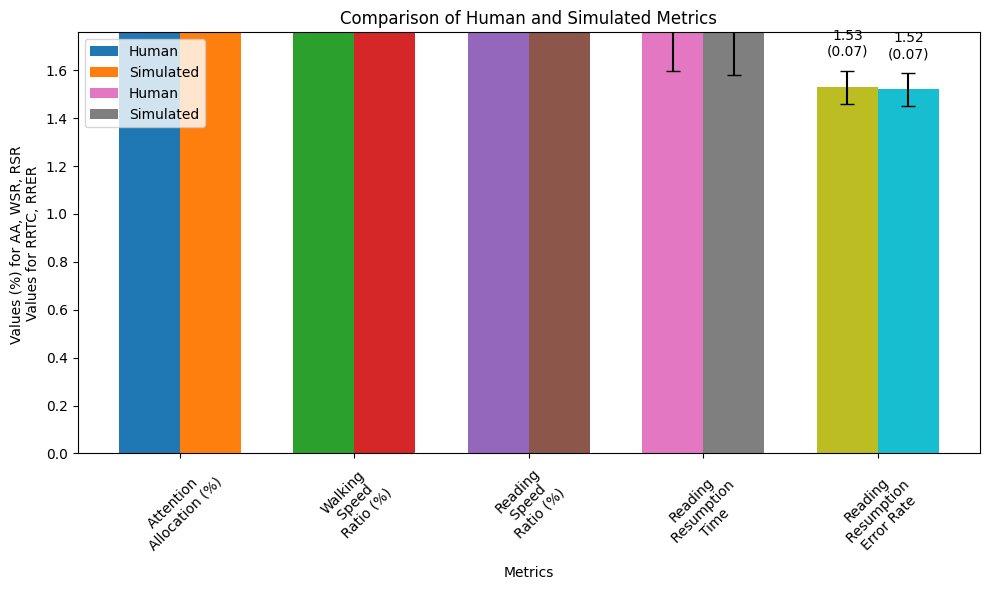

In [18]:
# Define the column pairs for human and simulated data
metric_pairs_aa_wsr_rsr = [
    ('hum_test_aas', 'sim_aas'),
    ('hum_test_wsrs', 'sim_wsrs'),
    ('hum_test_rsrs', 'sim_rsrs')
]

metric_pairs_rr = [
    ('Human Test Durations', 'Simulated and Tuned Durations'),
    ('Human Test Errors', 'Simulated and Tuned Errors')
]

# Function to adjust y-limit
def adjust_ylim(ax, means, stds):
    y_max = max(means + stds)
    ax.set_ylim(0, y_max * 1.15)  # Adding a bit of margin to the top

# Function to add annotations
def add_annotations(ax, rect, mean, std):
    height = rect.get_height()
    ax.annotate(f"{mean:.2f}\n({std:.2f})", 
                (rect.get_x() + rect.get_width() / 2, height + std + 0.05), 
                ha='center', va='bottom')

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

# Plot data from df_aa_wsr_rsr with percentage scale and std
for i, (hum_col, sim_col) in enumerate(metric_pairs_aa_wsr_rsr):
    hum_mean = df_aa_wsr_rsr[hum_col].mean() * 100  # Convert to percentage
    sim_mean = df_aa_wsr_rsr[sim_col].mean() * 100  # Convert to percentage
    hum_std = df_aa_wsr_rsr[hum_col].std() * 100  # Standard deviation to percentage
    sim_std = df_aa_wsr_rsr[sim_col].std() * 100  # Standard deviation to percentage
    
    hum_bar = ax.bar(index[i] - bar_width/2, hum_mean, bar_width, yerr=hum_std, capsize=5, label='Human' if i == 0 else "")
    sim_bar = ax.bar(index[i] + bar_width/2, sim_mean, bar_width, yerr=sim_std, capsize=5, label='Simulated' if i == 0 else "")
    
    # Annotate the bars with mean and std
    add_annotations(ax, hum_bar[0], hum_mean, hum_std)
    add_annotations(ax, sim_bar[0], sim_mean, sim_std)

# Plot data from df_rr with std
for i, (hum_col, sim_col) in enumerate(metric_pairs_rr, start=len(metric_pairs_aa_wsr_rsr)):
    hum_mean = df_rr[hum_col].mean()
    sim_mean = df_rr[sim_col].mean()
    hum_std = df_rr[hum_col].std()
    sim_std = df_rr[sim_col].std()
    
    hum_bar = ax.bar(index[i] - bar_width/2, hum_mean, bar_width, yerr=hum_std, capsize=5, label='Human' if i == len(metric_pairs_aa_wsr_rsr) else "")
    sim_bar = ax.bar(index[i] + bar_width/2, sim_mean, bar_width, yerr=sim_std, capsize=5, label='Simulated' if i == len(metric_pairs_aa_wsr_rsr) else "")
    
    # Annotate the bars with mean and std
    add_annotations(ax, hum_bar[0], hum_mean, hum_std)
    add_annotations(ax, sim_bar[0], sim_mean, sim_std)

# Adjust the ylim
all_means = [hum_mean, sim_mean] * len(metric_pairs_aa_wsr_rsr) + [hum_mean, sim_mean] * len(metric_pairs_rr)
all_stds = [hum_std, sim_std] * len(metric_pairs_aa_wsr_rsr) + [hum_std, sim_std] * len(metric_pairs_rr)
adjust_ylim(ax, all_means, all_stds)

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values (%) for AA, WSR, RSR \nValues for RRTC, RRER')
ax.set_title('Comparison of Human and Simulated Metrics')
ax.set_xticks(index)
ax.set_xticklabels(['Attention \nAllocation (%)', 'Walking\n Speed\n Ratio (%)', 'Reading\n Speed \nRatio (%)', 
                   'Reading\n Resumption \nTime', 'Reading\n Resumption \nError Rate'], rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()